In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output
from alb_LAI_util import generate_array_dif, generate_array_same, modify_attr,func_parse_date

# Parameters to tune for LAI (non-crop vegetation)

- `BaseT`
- `BaseTe`
- `LAIMAX`
- `LAIMin`

# Necessary functions for analysis

## To read attributes from csv files

In [2]:
# def generate_array_dif(attrs_site, attr,level):
#     dar = [0.75,0.5,.25]
#     dar[level] = attrs_site[attr].values[0]
#     return dar


# def generate_array_same(attrs_site, attr):
#     a = attrs_site[attr].values[0]
#     return [a, a, a]

## Modifying `df_state_init` for each land cover

In [3]:
# def modify_attr(df_state_init, df, name):


#     all_attrs = pd.read_csv('all_attrs.csv')
#     attrs_site = all_attrs[all_attrs.site == name]
#     df_state_init.loc[:, 'emissionsmethod'] = 0

#     if attrs_site.land.values[0] == 'DecTr':
#         ar = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
#         level = 1
#         df_state_init.loc[:, 'dectreeh'] = attrs_site.height.values[0]
#     elif attrs_site.land.values[0] == 'EveTr':
#         ar = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
#         level = 0
#         df_state_init.loc[:, 'evetreeh'] = attrs_site.height.values[0]
#     elif attrs_site.land.values[0] == 'Grass':
#         ar = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
#         level = 2
#         df_state_init.loc[:,'roughlenmommethod']=1
#         df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*.1
#         df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*.7
#     else:
#         print('The land cover type is not found! using the default one')

#     df_state_init.loc[:, 'sfr'] = ar
#     df_state_init.loc[:, 'lat'] = df.Latitude.values[0].values[0]
#     df_state_init.loc[:, 'lng'] = df.Longitude.values[0].values[0]
#     df_state_init.loc[:, 'z'] = attrs_site.meas.values[0]
#     df_state_init.loc[:, 'laimin'] = generate_array_dif(attrs_site, 'laimin',level)
#     df_state_init.loc[:, 'laimax'] = generate_array_dif(attrs_site, 'laimax',level)
#     df_state_init.loc[:, 'gddfull'] = generate_array_same(attrs_site, 'gddfull')
#     df_state_init.loc[:, 'sddfull'] = generate_array_same(attrs_site, 'sddfull')
#     df_state_init.loc[:, 'basete'] = generate_array_same(attrs_site, 'basete')
#     df_state_init.loc[:, 'baset'] = generate_array_same(attrs_site, 'baset')
#     df_state_init.lai_id = df_state_init.loc[:, 'laimin']

#     return df_state_init,level

## Reading data (including LAI data)

In [4]:
def read_data(year, name):

    df = pd.read_csv('data/MODIS_LAI_AmeriFlux/statistics_Lai_500m-' + name +
                     '.csv')
    if name!='crop':
        df.columns = ['product'
                      ] + [i.split(' ')[1] for i in df.columns if i != 'product']
        
    df = df.filter(['modis_date', 'value_mean'])

    df_period = df[[i.startswith('A' + str(year)) for i in df.modis_date]]
    df_period.loc[:, 'DOY'] = [
        int(i.split('A' + str(year))[1]) for i in df_period.modis_date
    ]
    df_period = df_period.set_index('DOY')

    copyfile("./runs/data/" + name + "_" + str(year) + "_data_60.txt",
             "runs/run/input/Kc_2012_data_60.txt")
    df_forcing = pd.read_csv('runs/run' + '/Input/' + 'kc' + '_' + '2012' +
                             '_data_60.txt',
                             sep=' ',
                             parse_dates={'datetime': [0, 1, 2, 3]},
                             keep_date_col=True,
                             date_parser=func_parse_date)

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)

    df_state_init ,level= modify_attr(df_state_init, df, name)

    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    df_output, df_state_final = sp.run_supy(df_forcing_run,
                                            df_state_init,
                                            save_state=False)
    
    return df_output, df_state_final, df_state_init, df_period, grid, df_forcing_run,level



## Calculating some of the variables of the models (LAI,GDD,SDD,Tair)

In [5]:
def calc_vars(df_output, grid, df_forcing_run,year,level):

    df_output_2 = df_output.loc[grid, :]
    df_output_2 = df_output_2[df_output_2.index.year >= year]

    lai_model = pd.DataFrame(df_output_2.SUEWS.LAI)
    a = lai_model.index.strftime('%j')
    lai_model['DOY'] = [int(b) for b in a]
    
    if(level==1):
        nameGDD='GDD_DecTr'
        nameSDD='SDD_DecTr'
    elif(level==0):
        nameGDD='GDD_EveTr'
        nameSDD='SDD_EveTr'
    if(level==2):
        nameGDD='GDD_Grass'
        nameSDD='SDD_Grass'

    GDD_model = pd.DataFrame(df_output_2.DailyState[nameGDD])
    a = GDD_model.index.strftime('%j')
    GDD_model['DOY'] = [int(b) for b in a]
    GDD_model = GDD_model.dropna()
    GDD_model = GDD_model.iloc[1:]

    SDD_model = pd.DataFrame(df_output_2.DailyState[nameSDD])
    print(SDD_model)
    a = SDD_model.index.strftime('%j')
    SDD_model['DOY'] = [int(b) for b in a]
    SDD_model = SDD_model.dropna()
    SDD_model = SDD_model.iloc[1:]

    Tair = df_forcing_run.Tair.resample('1d', closed='left',
                                        label='right').mean()
    Tair = pd.DataFrame(Tair)
    a = Tair.index.strftime('%j')
    Tair['DOY'] = [int(b) for b in a]

    return lai_model, GDD_model, SDD_model, Tair,nameGDD,nameSDD

## Calculating and plotting LAI for tuning site (and saving to pickle file)

In [6]:
def LAI_tune(year,name):
    df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run,level = read_data(year,name)
    lai_model,GDD_model,SDD_model,Tair,nameGDD,nameSDD=calc_vars(df_output,grid,df_forcing_run,year,level)
    clear_output()

    with open('outputs/LAI/'+name+'-'+str(year)+'-MODIS.pkl','wb') as f:
        pickle.dump(df_period, f)
    with open('outputs/LAI/'+name+'-'+str(year)+'-Model.pkl','wb') as f:
        pickle.dump(lai_model, f)

    attrs=[
    df_state_init.loc[:,'laimin'].loc[grid][level],
    df_state_init.loc[:,'laimax'].loc[grid][level],
    df_state_init.loc[:,'basete'].loc[grid][level],
    df_state_init.loc[:,'baset'].loc[grid][level]
    ]

    with open('outputs/LAI/'+name+'-attrs.pkl','wb') as f:
            pickle.dump(attrs, f)

    plt.rcParams.update({'font.size': 15})
    fig,axs=plt.subplots(2,1,figsize=(20,10))
    ax=axs[0]
    ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
    df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
    ax.set_ylabel('LAI')
    ax.legend()
    ax.set_title(name+'-'+str(year))
    ax.set_xlabel('')

    ax=axs[1]
    plt.scatter(Tair.DOY,Tair.Tair,color='k')


    
    try:
        max_y=30
        for gdd_day in [90,100,110,120,130,140,150,170,180,210,260]:
            a=GDD_model[GDD_model.DOY==gdd_day][nameGDD]
            plt.plot([gdd_day,gdd_day],[-15,max_y],color='r')
            plt.annotate(str(np.round(a.values[0],0)),(gdd_day-5,-14),color='r',rotation=90)


        for sdd_day in [150,170,180,200,250,270,300,310,320,330,340,350,360]:
            a=SDD_model[SDD_model.DOY==sdd_day][nameSDD]
            plt.plot([sdd_day,sdd_day],[-15,max_y],color='b')
            plt.annotate(str(np.round(a.values[0],0)),(sdd_day-5,-14),color='b',rotation=90)
    except:
        pass

    ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
    ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
    ax.legend()
    plt.ylabel('Tair (C)')
    plt.xlabel('DOY')
    ax.set_xlim(left=0,right=365)

## Calculating and plotting LAI for Testing sites (and saving them to pickle files)

In [7]:
def LAI_test(years,name):
    
    plt.rcParams.update({'font.size': 12})
    fig,axs=plt.subplots(len(years),2,figsize=(20,13))

    counter=-1
    for year in years:
        print(name+'-'+str(year))
        counter=counter+1
        df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run,level = read_data(year,name)
        lai_model,GDD_model,SDD_model,Tair,nameGDD,nameSDD=calc_vars(df_output,grid,df_forcing_run,year,level)
        clear_output()

        with open('outputs/LAI/'+name+'-'+str(year)+'-MODIS.pkl','wb') as f:
            pickle.dump(df_period, f)
        with open('outputs/LAI/'+name+'-'+str(year)+'-Model.pkl','wb') as f:
            pickle.dump(lai_model, f)


        ax=axs[counter][0]
        ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
        df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
        ax.set_ylabel('LAI')
        if counter==0:
            ax.legend()
        if counter!=len(years)-1:
            ax.set_xlabel('')
        ax.set_title(name+'-'+str(year))




        ax=axs[counter][1]
        ax.scatter(Tair.DOY,Tair.Tair,color='k')
        try:
            max_y=30
            for gdd_day in [90,110,130,150]:
                a=GDD_model[GDD_model.DOY==gdd_day][nameGDD]
                ax.plot([gdd_day,gdd_day],[-15,max_y],color='r')
                ax.annotate(str(np.round(a.values[0],0)),(gdd_day-10,-14),color='r',rotation=90)


            for sdd_day in [300,320,340,360]:
                a=SDD_model[SDD_model.DOY==sdd_day][nameSDD]
                ax.plot([sdd_day,sdd_day],[-15,max_y],color='b')
                ax.annotate(str(np.round(a.values[0],0)),(sdd_day-10,-14),color='b',rotation=90)
        except:
            pass
        ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
        ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
        if counter==0:
            ax.legend()
        ax.set_ylabel('Tair (C)')
        if counter==len(years)-1:
            ax.set_xlabel('DOY')
        ax.set_xlim(left=0,right=365)
        ax.set_title(name+'-'+str(year))

    plt.savefig('figs/'+name+'-LAI.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# Plotting for all the sites

## DecTr

### US-MMS

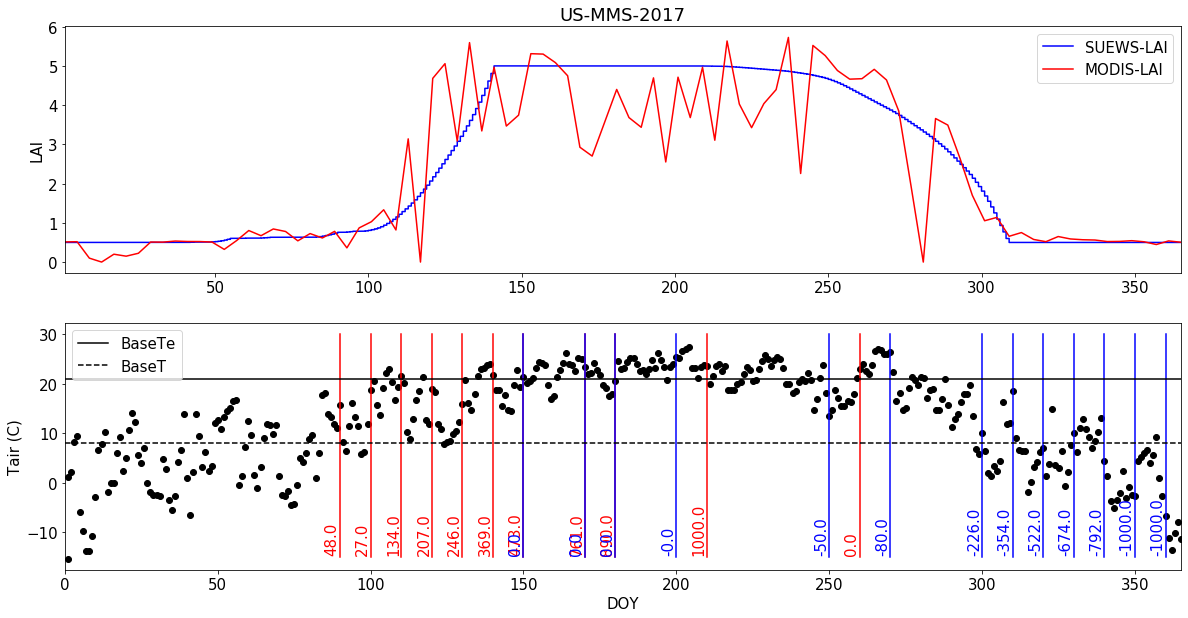

In [8]:
name='US-MMS'
year=2017
LAI_tune(year,name)

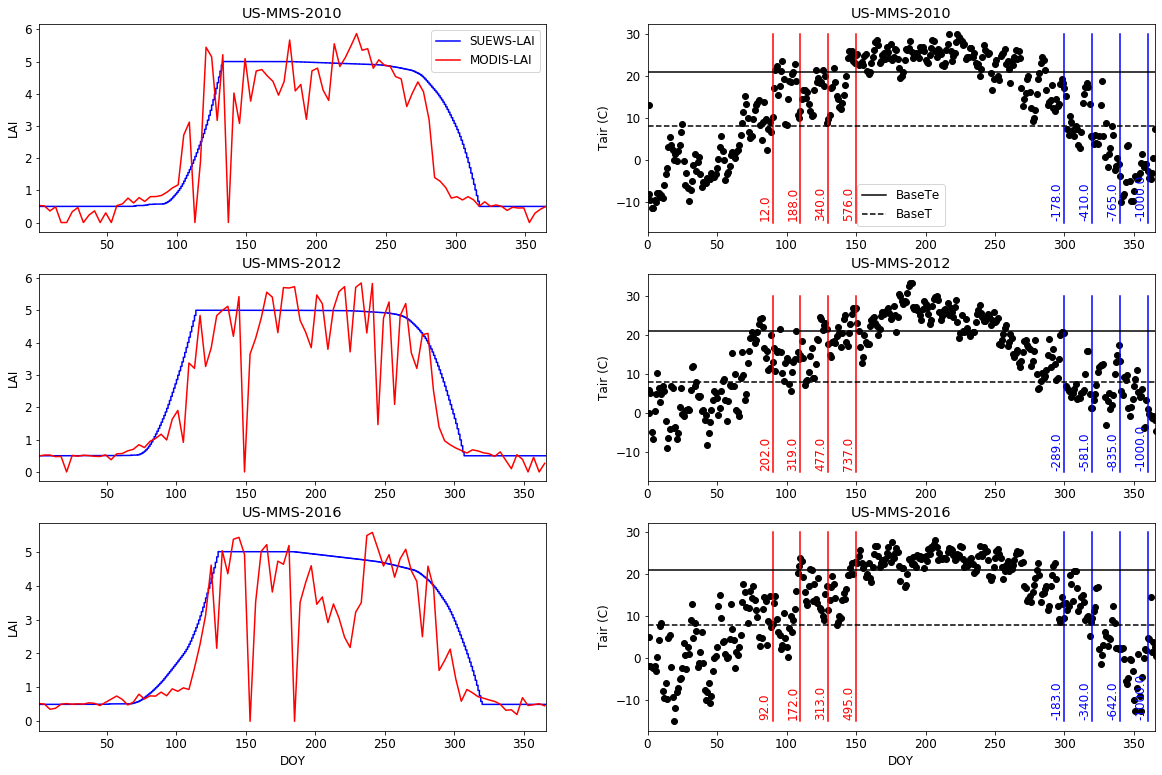

In [9]:
name='US-MMS'
years=[2010,2012,2016]
LAI_test(years,name)

### US-UMB

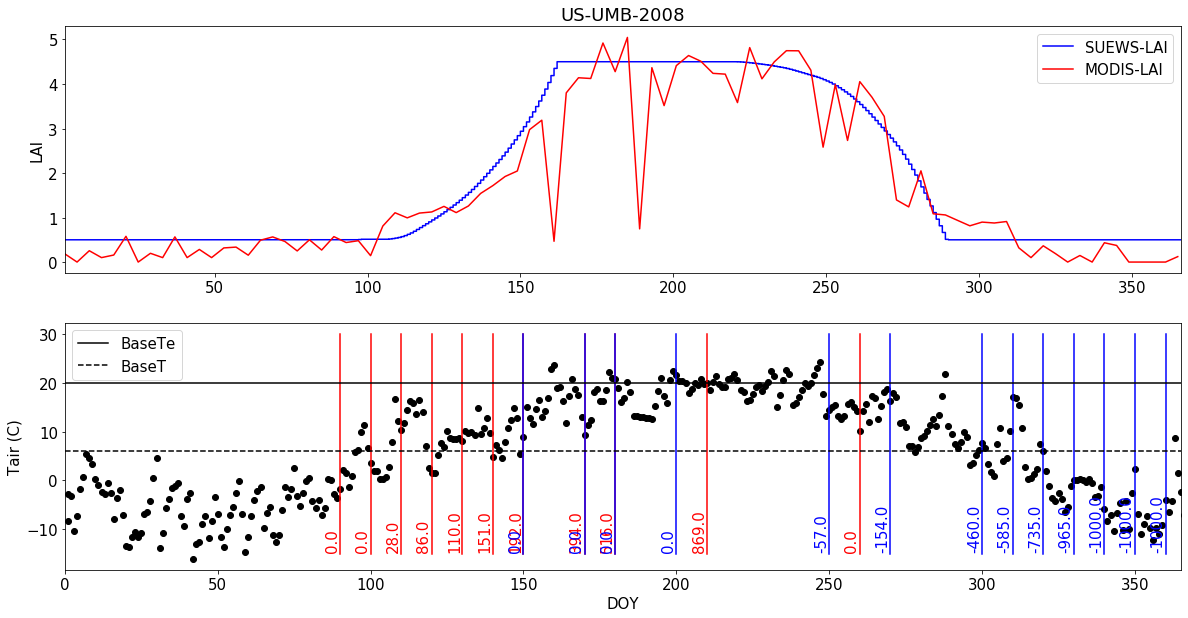

In [40]:
name='US-UMB'
year=2008
LAI_tune(year,name)

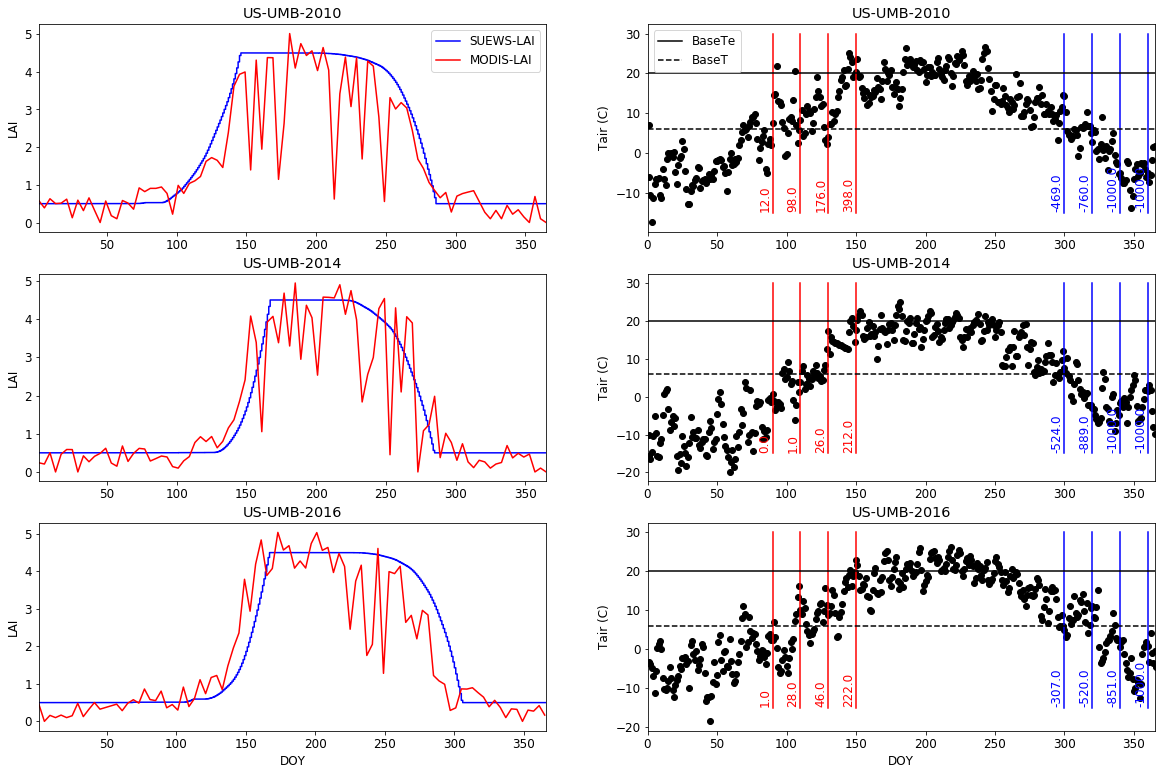

In [41]:
name='US-UMB'
years=[2010,2014,2016]
LAI_test(years,name)

### US-Oho

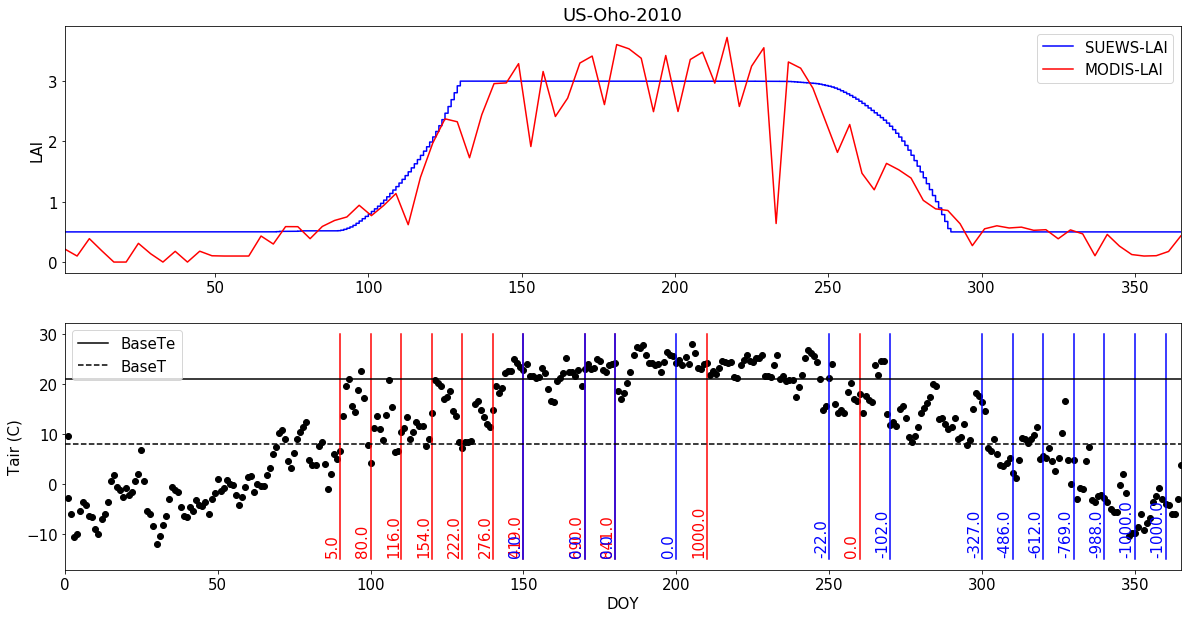

In [42]:
name='US-Oho'
year=2010
LAI_tune(year,name)

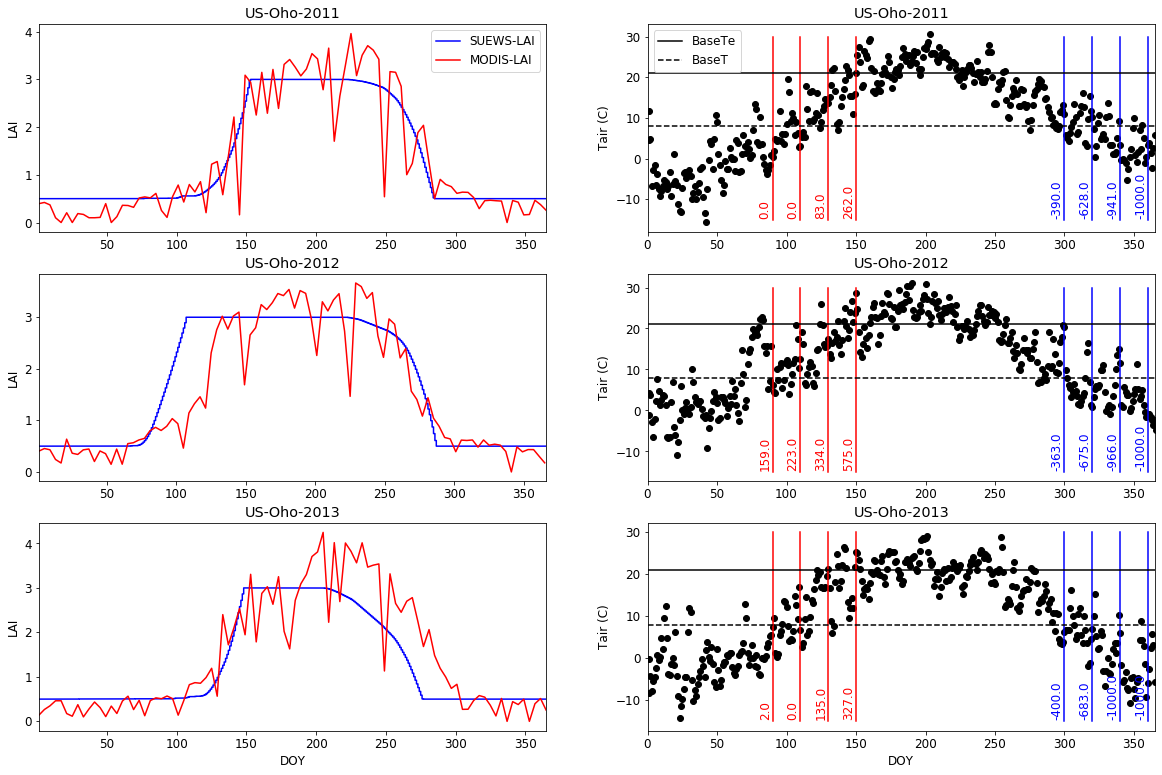

In [43]:
name='US-Oho'
years=[2011,2012,2013]
LAI_test(years,name)

## EveTr

### US-Blk

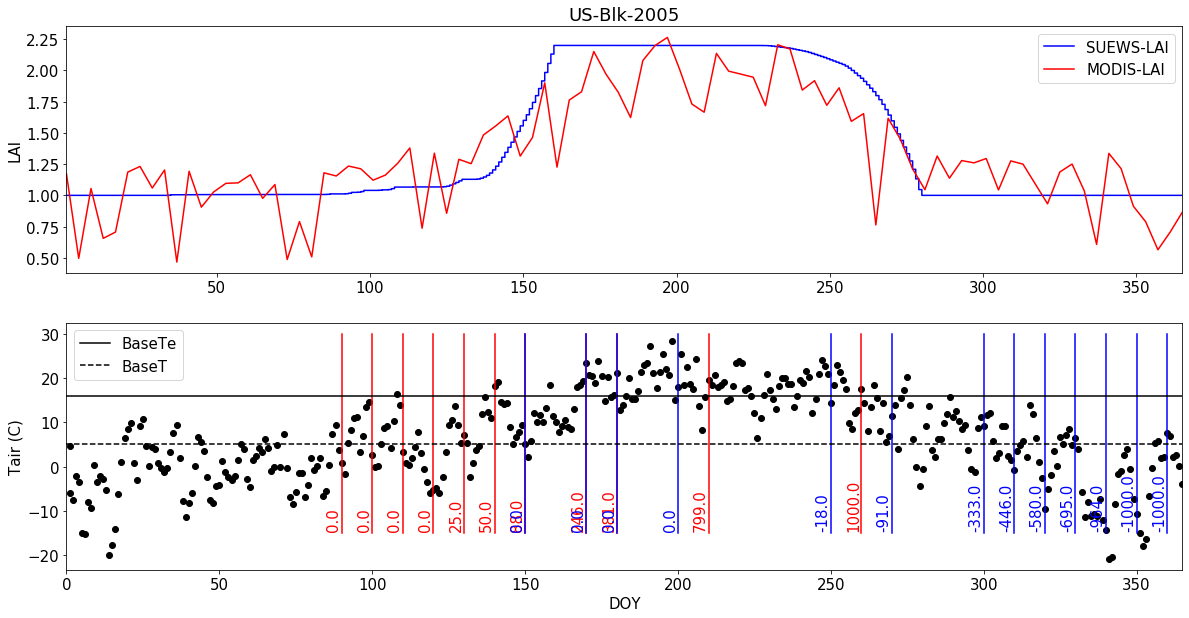

In [44]:
name = 'US-Blk'
year = 2005
LAI_tune(year, name)

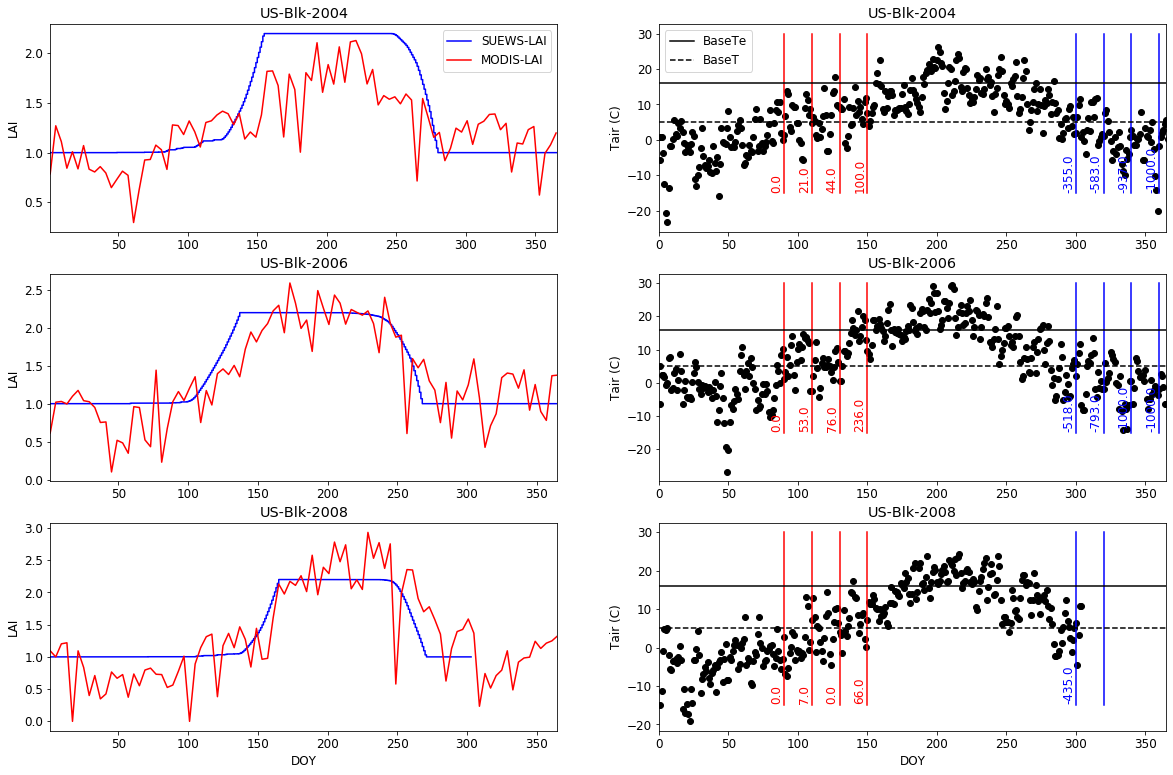

In [45]:
name = 'US-Blk'
years = [2004, 2006, 2008]
LAI_test(years, name)

### CA-Obs

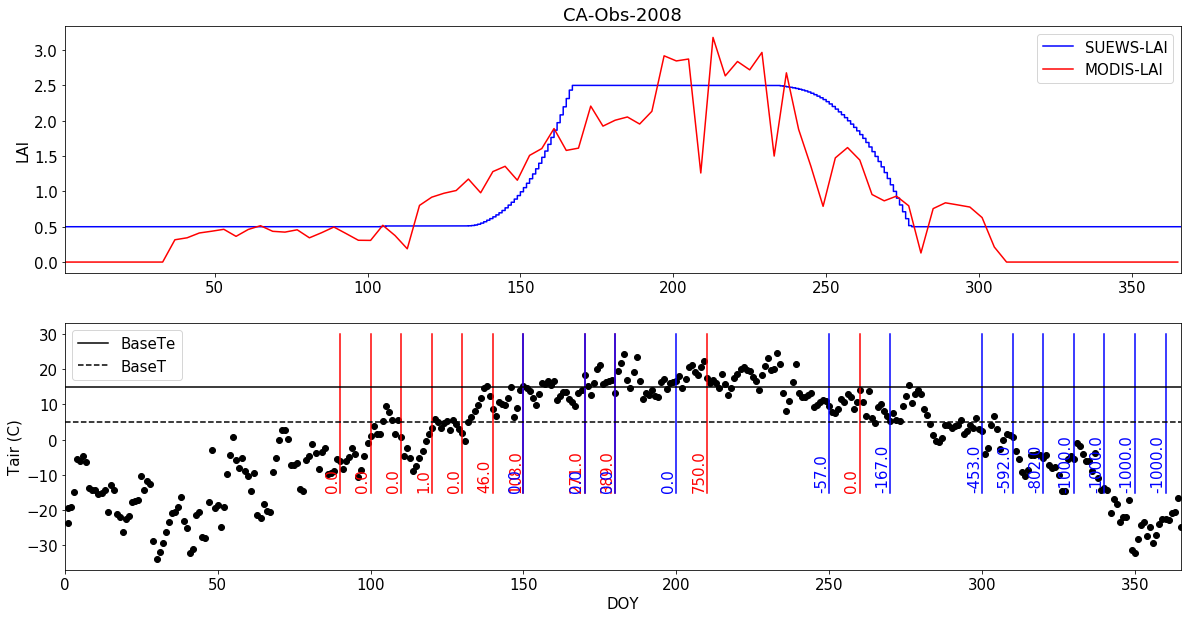

In [46]:
name = 'CA-Obs'
year = 2008
LAI_tune(year, name)

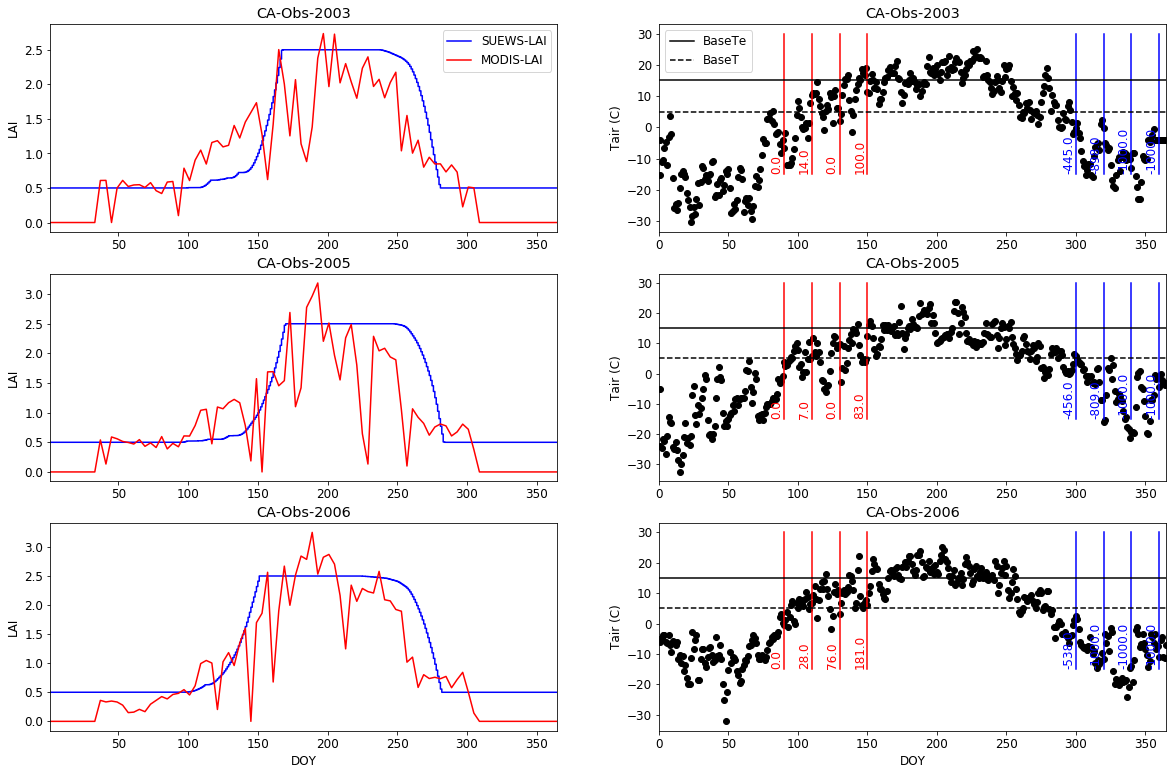

In [47]:
name = 'CA-Obs'
years = [2003, 2005, 2006]
LAI_test(years, name)

### CA-Qcu

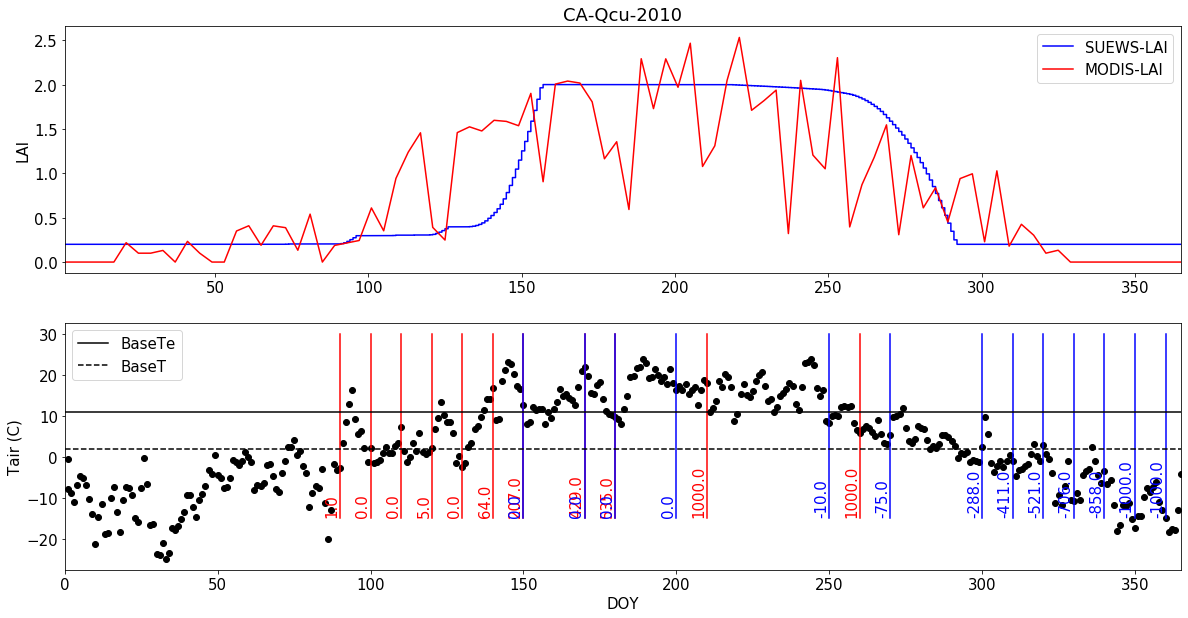

In [48]:
name = 'CA-Qcu'
year = 2010
LAI_tune(year, name)

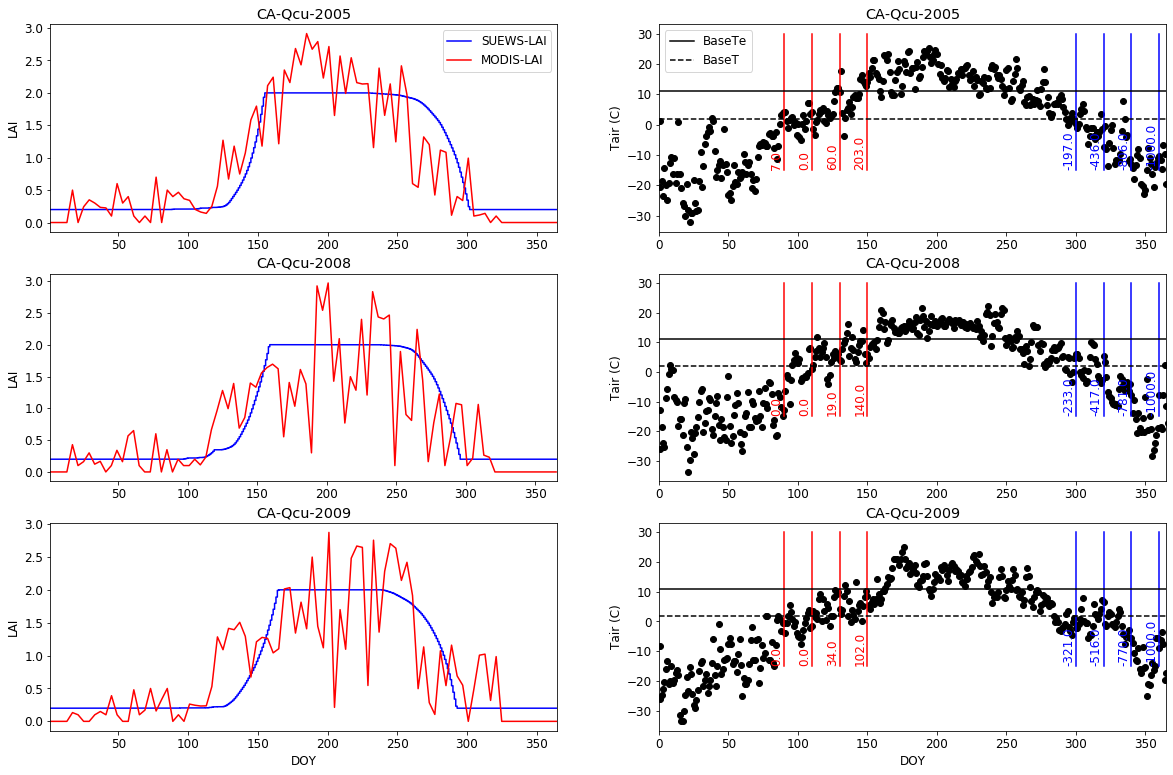

In [49]:
name = 'CA-Qcu'
years = [2005, 2008, 2009]
LAI_test(years, name)

## Grass

### US-AR1

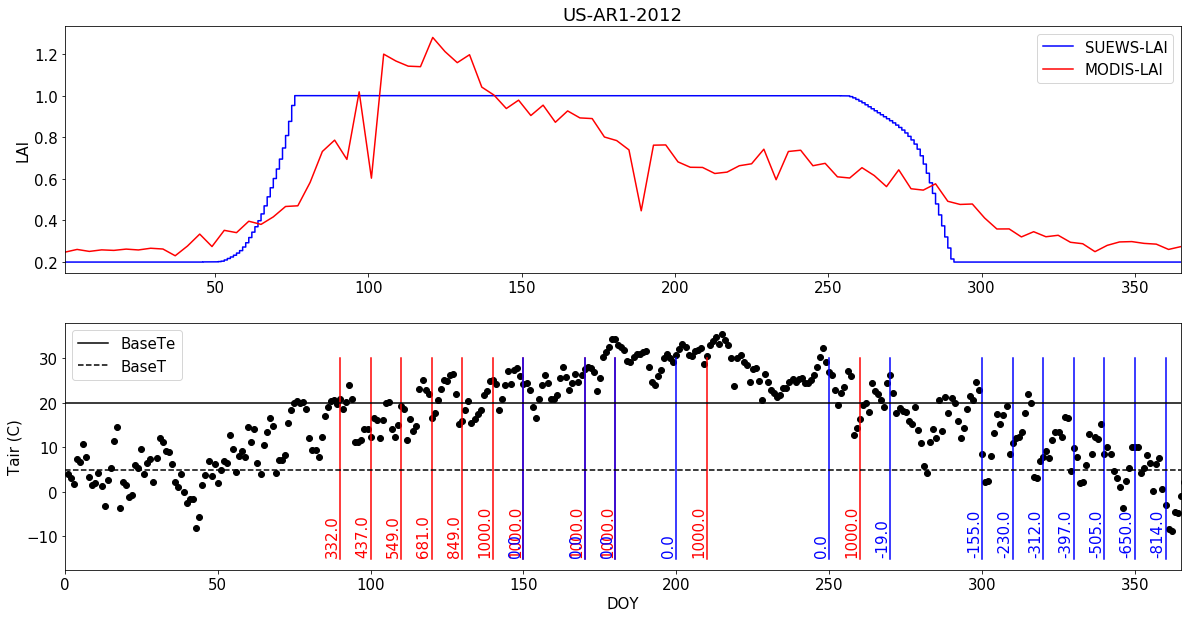

In [50]:
name = 'US-AR1'
year = 2012
LAI_tune(year, name)

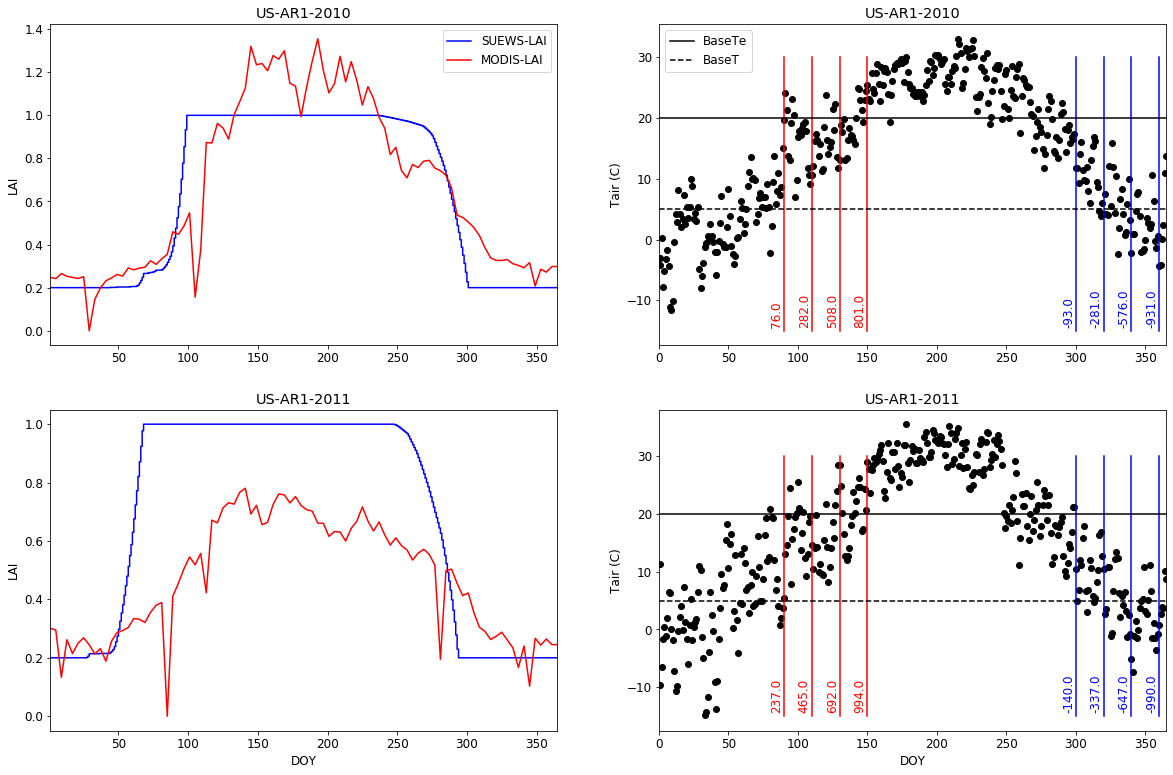

In [51]:
name = 'US-AR1'
years = [2010, 2011]
LAI_test(years, name)

### US-KUT

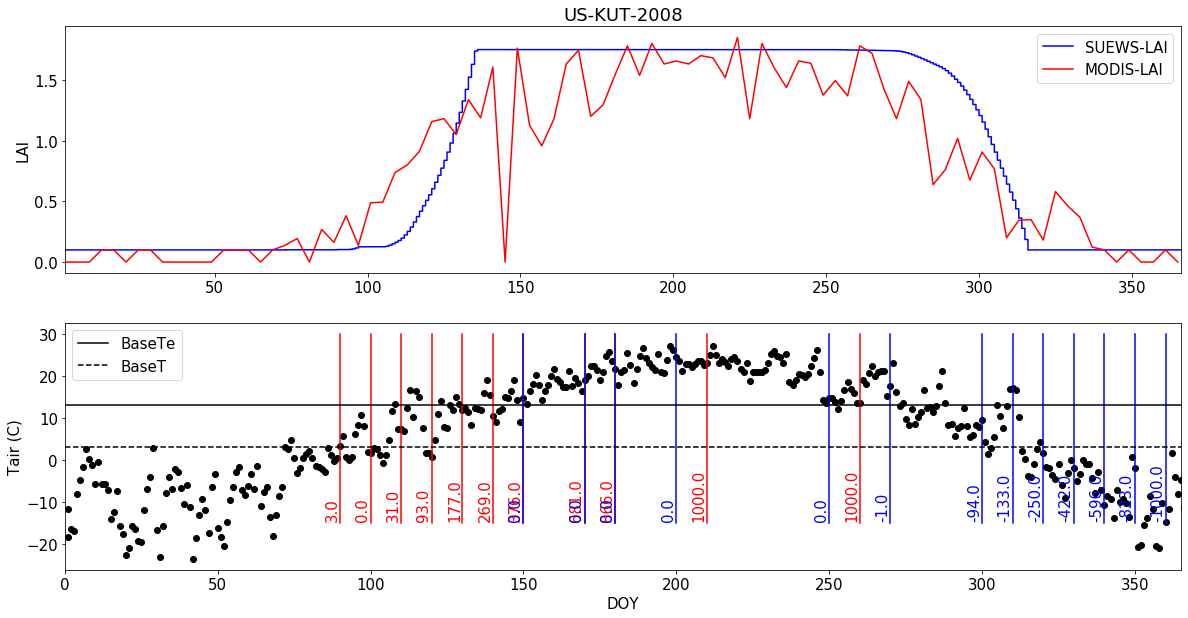

In [52]:
name = 'US-KUT'
year = 2008
LAI_tune(year, name)

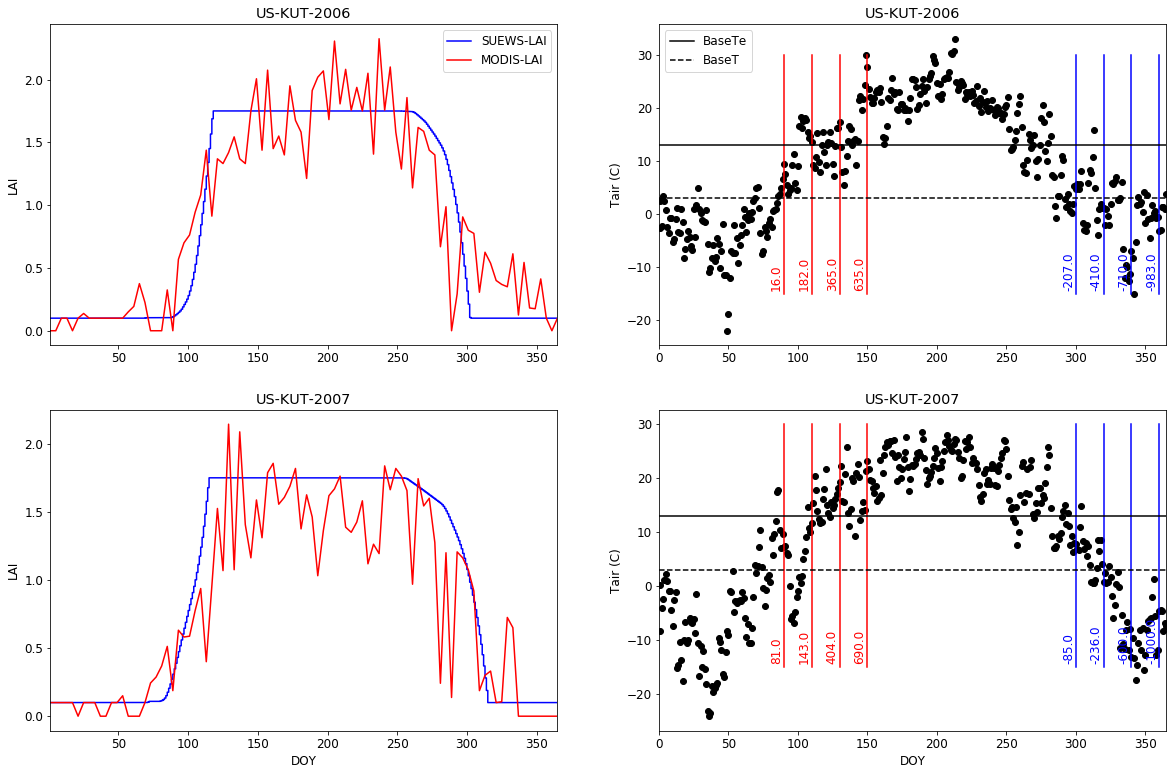

In [53]:
name = 'US-KUT'
years = [2006, 2007]
LAI_test(years, name)